In [1]:
## Importing required Libraries
import os
import tensorflow as tf
from tensorboard.plugins import projector
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score

In [2]:
#Step 1:Load the data
df = pd.read_csv("Journey_Clusters_5.csv")

#df=df.drop(columns=['clusterID'])
df=df.drop(df.columns[0], axis=1)
df.head()

,user_id,product_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase,clusterID
0,586731299,5802440,2,2,22192.0,2.16,2.16,1,0,0,...,1,1,0,0,0,0,0,0,1,1
1,569852676,4938,2,1,499.0,1.43,1.43,1,0,0,...,0,0,0,0,1,0,0,0,1,1
2,448826103,5814048,3,2,7226454.0,6.27,5.95,2,0,0,...,0,0,0,0,0,0,0,1,1,3
3,448826103,5814047,2,1,1381.0,6.27,6.27,1,0,0,...,0,0,0,0,0,0,0,1,1,1
4,448826103,5787041,5,1,374.0,9.52,9.52,4,0,0,...,0,0,0,0,0,0,0,1,1,1


In [3]:
#Step 2: Pre-process to remove columns that are not needed
df=df.drop(['user_id','product_id'], axis=1)
from sklearn.utils import shuffle
df = shuffle(df)
df.head()

,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,InsessionCart,InsessionView,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Purchase,clusterID
9501628,3,1,385.0,3.00,3.00,1,0,2,23,7,...,0,0,0,1,0,0,0,0,0,1
3814009,1,1,0.0,44.44,44.44,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
9408802,2,2,255891.0,25.71,25.71,0,2,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4592010,1,1,0.0,9.37,9.37,0,1,0,12,37,...,0,0,0,0,1,0,0,0,0,1
7425112,1,1,0.0,1.27,1.27,1,0,0,20,0,...,0,0,0,0,0,1,0,0,0,1


In [4]:
print('Size of the data set=',df.shape)
for col in df.columns: 
    print(col) 

Size of the data set= (10156200, 35)
NumOfEventsInJourney
NumSessions
interactionTime
maxPrice
minPrice
NumCart
NumView
NumRemove
InsessionCart
InsessionView
InsessionRemove
Weekend
Fr
Mon
Sat
Sun
Thu
Tue
Wed
2019
2020
Jan
Feb
Oct
Nov
Dec
Afternoon
Dawn
EarlyMorning
Evening
Morning
Night
Noon
Purchase
clusterID


In [5]:
#########################################
###################Only this needs changing
frac=0.1 # This is the fraction of subsampled data that will be subsequently analyzed. 
#Change this to 0.2/0.3 for completed analysis
##########Thats all!

In [6]:
#Step 3: subsample each cluster to 1-20% as df_sub and then analyze
#For complete analysis consider several random sub-sampling and averaging the outcomes
column_values = df["clusterID"]. values. ravel()
unique_values_a = np.array(pd.unique(column_values))
unique_values=np.sort(unique_values_a) # This is the unique cluster identifiers


data=[]
df_sub = pd.DataFrame(data, columns=(df.columns.values[0:34]))

for index, item in enumerate(unique_values):
    locations=df.loc[df['clusterID'] == item]
    ret_size=np.round(frac*locations.shape[0]).astype(int)#sub-sampling to predetermined amount
    print('Number of samples for class', item, '=',ret_size)
    rows=np.random.permutation(ret_size)
    loc_data=locations.iloc[rows,:]
    df_sub=df_sub.append(loc_data)
print('Total number of samples in the new subsampled data set=',df_sub.shape[0])

Number of samples for class 0 = 22272
Number of samples for class 1 = 926188
Number of samples for class 2 = 6267
Number of samples for class 3 = 11833
Number of samples for class 4 = 49060
Total number of samples in the new subsampled data set= 1015620


# Step 4: Begin semi-supervised Learning Process:
The process is is as follows:
1. Pick a particular cluster at a time
2. For all samples in the cluster randomly remove [10, 20, 30 40,50, 60, 70]% labels. This means for a lot of samples the Y-labels=-1 instad of [0,1]
3. Apply label propagation to cluster samples. The goal is to retrieve the dropped sample label automatically using the sample neighbors. The parameters here will be 'k' value for k-NN and $\alpha$
4. Compute accuracy in prediction of purchase, vs no purchase for each instance.
5. Repeat step 2-4 atleast 20 times for each cluster. Note the average and std of accuracy for each random dop rate.

Outcome is a graph, y-axis: accuracy of purchase vs no purchase classification, x-axis: % randomly dropped samples.

Goal: If the accuracy vs drop sample rate is  relatively steady for a particular cluster, that cluster is robust to partial labelling issues and it will be more genneralizable in real time than clusters that are very unpredictable (high variations in prediction accuracies).

In [7]:
X=np.array(df_sub[df_sub.columns[0:10]])
Y=np.array(df_sub[df_sub.columns[34]])# Y=clusterID
P=np.array(df_sub[df_sub.columns[33]]).astype(int)#P=purchase vs not
############################# Reduce data dimensionality to speed up label propagation
pca = PCA(n_components=5)
pca.fit(X)
X1=pca.transform(X)

print(np.shape(X1))
#start with 2 clusters to 5 and show CH score increases as clusters increase

(1015620, 5)


In [8]:
#Normalize data to aid convergence
X1_n = (X1-X1.min(axis=0)) / (X1.max(axis=0)-X1.min(axis=0))
X1=X1_n
print(X1[0:5,:])
#Data pre-processing is now over, now lets start randomly dropping labels

[[0.18415635 0.0112148  0.24547377 0.00703695 0.06405749]
 [0.28303937 0.01067096 0.2410352  0.03091296 0.0255491 ]
 [0.25771888 0.00696774 0.24273302 0.10296854 0.02846567]
 [0.26522244 0.0067633  0.24227328 0.09871055 0.0262859 ]
 [0.24874754 0.00896176 0.24219431 0.03505471 0.03301506]]


In [9]:
#Step 4.1: Randomly drop labels
import matplotlib.pyplot as plt
c_vals=[1, 4,0,3,2] # These are cluster indices in incremental order of sample represnetation
dropP=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]#Fraction of population to be randomly dropped
acc=np.zeros((5,9,10))
f1=np.zeros((5,9,10))
for ci,item in enumerate(c_vals):
    locs=np.where(Y==item) #Locate all samples belonging to a particular cluster
    print('Processing samples of cluster=',item)
    Yn=P[locs]
    Xn=np.squeeze(X1[locs,:]) #subsample Xn from dimensionality reduced cluster features 
    n=np.shape(locs)[1]# number of samples per cluster
    ######################################################################
    #This loop needs to be rerun about 20 times each (add another loop)
    for cn in range(10):
        print(cn)
        for cp,drop in enumerate(dropP):
            Ynd=P[locs]
            ns=np.round(drop*n).astype(int)
            #print('num of samples dropped=',ns)
            dropI=np.floor(np.random.rand(ns)*n).astype(int)
            Ynd[dropI]=-1
            #Thus (Xn,Ynd) is the new data that will be subjected to label propagation
            ################################### so random label removal works!
            #Step 4.2: Apply Label propagation to all samples
            lp_model = LabelSpreading(kernel='knn',n_neighbors=3,alpha=0.1) #high alpha means labels an change till stable
            # Train the model
            lp_model.fit(Xn, Ynd)


            #Step 4.3: Predict Model label for the dropped samples
            pred = lp_model.transduction_[dropI]
            #print('Predictions=',pred)
            #print('Groundtruth=',Yn[dropI])

            #Step 4.4: Compute accuracy, for predictions
            acc[ci,cp,cn] = accuracy_score(Yn[dropI], pred)
            f1[ci,cp,cn] = f1_score(Yn[dropI], pred)

Processing samples of cluster= 1
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 4
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 0
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 3
0
1
2
3
4
5
6
7
8
9
Processing samples of cluster= 2
0
1
2
3
4
5
6
7
8
9


In [10]:
a=np.mean(acc,axis=2)
f=np.mean(f1,axis=2)
print(np.shape(a))

(5, 9)


# Repeat the cell above 20 times and avarage the accross all runs to proceed forward!

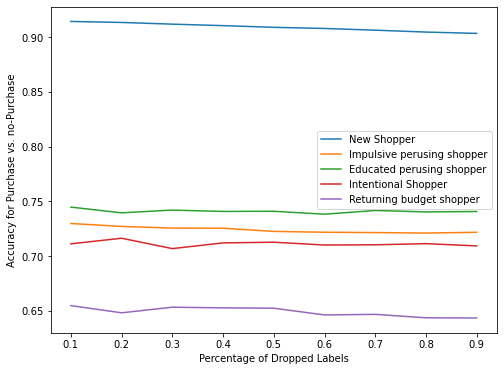

In [11]:
#Finally generate the plots per cluster
labs=['New Shopper','Impulsive perusing shopper','Educated perusing shopper','Intentional Shopper','Returning budget shopper']

plt.figure(figsize=(8,6))
plt.plot(dropP,a[0,:])
plt.plot(dropP,a[1,:])
plt.plot(dropP,a[2,:])
plt.plot(dropP,a[3,:])
plt.plot(dropP,a[4,:])
plt.legend(labs)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('Accuracy for Purchase vs. no-Purchase')
plt.show()



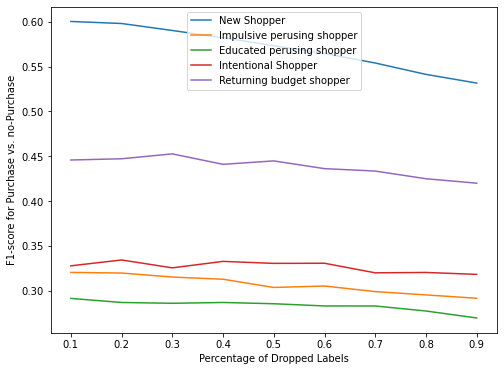

In [12]:
#Finally generate the plots per cluster
labs=['New Shopper','Impulsive perusing shopper','Educated perusing shopper','Intentional Shopper','Returning budget shopper']
plt.figure(figsize=(8,6))
plt.plot(dropP,f[0,:])
plt.plot(dropP,f[1,:])
plt.plot(dropP,f[2,:])
plt.plot(dropP,f[3,:])
plt.plot(dropP,f[4,:])
plt.legend(labs)
plt.xlabel('Percentage of Dropped Labels')
plt.ylabel('F1-score for Purchase vs. no-Purchase')
plt.show()